In [1]:
import sys
import os
import glob
from pathlib import Path
import random
import time
import datetime
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_curve, roc_auc_score
import re
import transformers
import torch 
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
%matplotlib inline
sns.set_theme(style='darkgrid')

In [2]:
from pkg.UTHBERT.preprocess_text import preprocess as my_preprocess
from pkg.UTHBERT.tokenization_mod import MecabTokenizer, FullTokenizerForMecab
from transformers import BertModel,BertConfig

In [3]:
def get_device() -> str:
    """
    Returns the best available device for PyTorch computations.
    """
    if torch.backends.mps.is_available():
        # macOS with Apple Silicon (MPS backend)
        return "mps"
    elif torch.cuda.is_available():
        # NVIDIA GPU
        return "cuda"
    else:
        # Fallback to CPU
        return "cpu"

try:
    device = torch.device(get_device())
    print(f"Using device: {device}")
except RuntimeError as e:
    print(f"Failed to initialize the device: {e}")
    device = torch.device("cpu")  # Fallback to CPU in case of an error

Using device: mps


In [4]:
seed=0
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False #Trueで高速化重視, Falseで再現性重視
seed_everything(seed)
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
torch.use_deterministic_algorithms(True)
torch.set_num_threads(1)

# Tokenizer

In [5]:
dic_path = './dic'

In [6]:
# special token for a Person's name (Do not change)
name_token = "＠＠Ｎ"

# path to the mecab-ipadic-neologd
mecab_ipadic_neologd = dic_path + '/mecab-ipadic-neologd'

# path to the J-Medic (We used MANBYO_201907_Dic-utf8.dic)
mecab_J_medic = dic_path + '/MANBYO/MANBYO_201907_Dic-utf8.dic'

# path to the uth-bert vocabulary
vocab_file = dic_path + '/UTH-BERT/bert_vocab_mc_v1_25000.txt'

In [7]:
# MecabTokenizer
sub_tokenizer = MecabTokenizer(mecab_ipadic_neologd=mecab_ipadic_neologd,
                               mecab_J_medic=mecab_J_medic,
                               name_token=name_token)

# FullTokenizerForMecab
tokenizer = FullTokenizerForMecab(sub_tokenizer=sub_tokenizer,
                                  vocab_file=vocab_file,
                                  do_lower_case=False)

In [8]:
def tokenize(sentence_list):
    token_list = []
    for s in tqdm(sentence_list):
        tokens = tokenizer.tokenize(my_preprocess(str(s)))
        ids = tokenizer.convert_tokens_to_ids(tokens)
        ids = [2] + ids + [3]
        token_list.append(ids)
    return token_list

# Data

In [9]:
def create_dataframe(folder_path):
    """
    指定されたフォルダ内のテキストファイルからDataFrameを作成する関数

    Args:
        folder_path (str): テキストファイルが入っているフォルダのパス

    Returns:
        pandas.DataFrame: 作成されたDataFrame
    """

    # フォルダ内のすべてのテキストファイルのパスを取得
    file_list = glob.glob(folder_path + "/*.txt")

    # 空のDataFrameを作成
    df_text = pd.DataFrame(columns=['id', 'text'])
    
    # label.csvを読み込む
    df_label = pd.read_csv(os.path.join(folder_path, "label.csv"))

    for file in file_list:
        # ファイル名からIDを抽出
        file_id = file.split("/")[-1].split(".")[0]
        # file_id = file.split("\\")[-1].split(".")[0] # Windows
        
        # テキストファイルを読み込む
        with open(file, 'r', encoding='utf-8') as f:
            text = f.read()

        # DataFrameに追記
        rows = []
        rows.append({'id': int(file_id), 'text': text})
        df_text = pd.concat([df_text, pd.DataFrame(rows)], ignore_index=True)
        
    # textとlabelのDataFrameを結合
    df = pd.merge(df_text, df_label, on='id', how='left')

    return df

train_folder_path = "../../radnlp_2024_train_val_20240731/ja/main_task/train"
train_df = create_dataframe(train_folder_path)
val_folder_path = "../../radnlp_2024_train_val_20240731/ja/main_task/val"
val_df = create_dataframe(val_folder_path)

In [10]:
train_df

,id,text,t,n,m
0,4166189,左肺上葉に長径 12cm の腫瘤を認めます。弓部大動脈や肺動脈浸潤が疑われます。\nT4 と...,T4,N2,M0
1,1185427,右下葉に長径 30mm 大の腫瘤を認め、肺癌を疑います。葉間胸膜の陥入を伴い、臓\n側胸膜浸...,T1c,N0,M0
2,165742,右肺尖部に長径 5 ㎝の腫瘤を認めます。辺縁に棘状影が見られ原発性肺癌を疑いま\nす。壁側胸...,T3,N0,M0
3,6848850,両側肺野に肺気腫を認めます。\n右肺下葉に分葉状腫瘤性病変を認めます（最大径 37×37×4...,T2a,N2,M1c
4,9818606,肺野背景に気腫性変化を認めます。\n右肺下葉に長径 40mm の腫瘤を認めます。分葉状の形態...,T2a,N2,M1c
...,...,...,...,...,...
103,15410359,比較可能な画像検査はありません。\n右肺尖部に長径 50mm 大の腫瘤影を認めます。病変は...,T2b,N0,M0
104,8602016,右肺門部に軟部影を認め、ご指摘の悪性腫瘍が疑われます。右下葉は無気肺となっ\nています。\n...,T2a,N3,M0
105,1876861,肺野は背景に慢性肺気腫の所見を認めます。\n右肺尖部に⻑径 48mm の不整形腫瘤を認め、原...,T2b,N2,M1b
106,13567317,背景に間質性肺炎、肺気腫を疑います。気腫合併肺線維症のような肺癌の発生しや\nすい状態を疑い...,T2b,N2,M0


In [11]:
print(train_df['t'].value_counts())
print(train_df['n'].value_counts())
print(train_df['m'].value_counts())

t
T4     31
T2a    20
T2b    19
T3     18
T1b     9
T1c     8
T0      3
Name: count, dtype: int64
n
N2    45
N0    41
N1    13
N3     9
Name: count, dtype: int64
m
M0     74
M1c    20
M1b    14
Name: count, dtype: int64


In [12]:
add_df = pd.read_csv("../add_data.csv", encoding = 'cp932')

In [13]:
add_df

,id,text,t,n,m
0,0,原発腫瘍を認めない,T0,N0,M0
1,1,上皮内癌（carcinoma in situ）：肺野型の場合は、充実成分径0cmかつ病変全体...,Tis,N0,M0
2,2,微少浸潤性腺癌：部分充実型を示し、充実成分径≦0.5cmかつ病変全体径≦3cm。かつ肺または...,T1mi,N0,M0
3,3,腫瘍の充実成分径≦1cmでかつTis・T1miには相当しない。かつ肺または臓側胸膜に覆われて...,T1a,N0,M0
4,4,腫瘍の充実成分径>1cmでかつ≦2cm。かつ肺または臓側胸膜に覆われている。かつ葉気管支より...,T1b,N0,M0
5,5,腫瘍の充実成分径>2cmでかつ≦3cm。かつ肺または臓側胸膜に覆われている。かつ葉気管支より...,T1c,N0,M0
6,6,腫瘍の充実成分径>3cmでかつ≦4cm。または充実成分径≦3cmでも以下のいずれかであるもの...,T2a,N0,M0
7,7,腫瘍の充実成分径>4cmでかつ≦5cm。または充実成分径≦3cmでも以下のいずれかであるもの...,T2b,N0,M0
8,8,充実成分径>5cmでかつ≦7cm。または充実成分径≦5cmでも以下のいずれかであるもの：壁側...,T3,N0,M0
9,9,充実成分径＞7cm、または大きさを問わず横隔膜、縦隔、心臓、大血管、気管、反回神経、食道、椎...,T4,N0,M0


In [14]:
# 訓練データを追加する
df_train = pd.concat([add_df, train_df])

In [15]:
df_train

,id,text,t,n,m
0,0,原発腫瘍を認めない,T0,N0,M0
1,1,上皮内癌（carcinoma in situ）：肺野型の場合は、充実成分径0cmかつ病変全体...,Tis,N0,M0
2,2,微少浸潤性腺癌：部分充実型を示し、充実成分径≦0.5cmかつ病変全体径≦3cm。かつ肺または...,T1mi,N0,M0
3,3,腫瘍の充実成分径≦1cmでかつTis・T1miには相当しない。かつ肺または臓側胸膜に覆われて...,T1a,N0,M0
4,4,腫瘍の充実成分径>1cmでかつ≦2cm。かつ肺または臓側胸膜に覆われている。かつ葉気管支より...,T1b,N0,M0
...,...,...,...,...,...
103,15410359,比較可能な画像検査はありません。\n右肺尖部に長径 50mm 大の腫瘤影を認めます。病変は...,T2b,N0,M0
104,8602016,右肺門部に軟部影を認め、ご指摘の悪性腫瘍が疑われます。右下葉は無気肺となっ\nています。\n...,T2a,N3,M0
105,1876861,肺野は背景に慢性肺気腫の所見を認めます。\n右肺尖部に⻑径 48mm の不整形腫瘤を認め、原...,T2b,N2,M1b
106,13567317,背景に間質性肺炎、肺気腫を疑います。気腫合併肺線維症のような肺癌の発生しや\nすい状態を疑い...,T2b,N2,M0


In [16]:
X_train, X_valid = tokenize(train_df['text'].values.tolist()), tokenize(val_df['text'].values.tolist())

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

In [17]:
def convert_list(text_list, label_dic):
    """
    リストのテキストを、指定された辞書に基づいて数値に変換します。

    Args:
        text_list (list): 変換したいテキストのリスト
        label_dic (dict): テキストと対応する数値の辞書

    Returns:
        list: 数値に変換されたリスト
    """

    num_list = []
    for text in text_list:
        # 辞書から対応する数値を取得
        num = label_dic.get(text, None)
        if num is not None:
            num_list.append(num)
        else:
            print(f"対応する数値が見つかりません: {text}")
    return num_list

label_dic_t = {'T0':0, 'Tis':1, 'T1mi':2, 'T1a':3, 'T1b':4, 'T1c':5, 'T2a':6, 'T2b':7, 'T3':8, 'T4':9}
Yt_train, Yt_valid = convert_list(train_df['t'].values.tolist(), label_dic_t), convert_list(val_df['t'].values.tolist(), label_dic_t)

label_dic_n = {'N0':0, 'N1':1, 'N2':2, 'N3':3}
Yn_train, Yn_valid = convert_list(train_df['n'].values.tolist(), label_dic_n), convert_list(val_df['n'].values.tolist(), label_dic_n)

label_dic_m = {'M0':0, 'M1a':1, 'M1b':2, 'M1c':3}
Ym_train, Ym_valid = convert_list(train_df['m'].values.tolist(), label_dic_m), convert_list(val_df['m'].values.tolist(), label_dic_m)

# TNM各々分類モデルを学習

In [18]:
model_path = Path('./pkg/UTHBERT')
save_path = Path('./model')

In [19]:
num_classes_t=10
num_classes_n=4
num_classes_m=4

In [20]:
class MyCollator(object):
    '''
    Args:
    test : Set True when using with test data loader. Defaults to False
    percentile : Trim sequences by this percentile
    '''
    def __init__(self,test=False,percentile=100):
        self.test = test
        self.percentile = percentile
    def __call__(self, batch):
        if not self.test:
            data = [torch.tensor(item[0])  for item in batch]
            target = [item[1] for item in batch]
        else:
            data = [item for item in batch]
        
        # Padding
        data = pad_sequence(data, batch_first=True)
        data = data.clone().detach().long()
        masks = torch.where(data==0, 1, 0)
        masks = masks.clone().detach().long()
        if not self.test:
            target = torch.tensor(target, dtype=torch.long)
            return [data, masks, target]
        return [data, masks]

In [21]:
def build_data(train_data, valid_data, batch_size=8): 
        
    collate = MyCollator(percentile=100)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=collate) 
    valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=collate) 
     
    return train_loader, valid_loader

In [22]:
config = BertConfig.from_json_file(model_path / 'bert_config.json')
bert = BertModel.from_pretrained(model_path / 'UTH_BERT.bin', config=config)

class Net(nn.Module):
    def __init__(self, bert, num_classes):
        super(Net, self).__init__()
        self.bert = bert
        self.cls = nn.Linear(768, num_classes)

  # @torch.cuda.amp.autocast()
    def forward(self, inputs_ids, pad_masks, Attention=False):
        bout = self.bert(inputs_ids, pad_masks, output_attentions=Attention)
        bs = len(bout[0])
        h0 = [bout[0][i][0] for i in range(bs)]
        h0 = torch.stack(h0,dim=0)
        if Attention:
            return self.cls(h0),bout
        else:
            return self.cls(h0)

In [23]:
def plot_loss(train_loss, valid_loss):
    plt.plot(train_loss)
    plt.plot(valid_loss)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['train_loss', 'valid_loss'], loc='upper right')
    plt.xticks(np.arange(0, epochs + 1, 5))
    plt.show()

In [24]:
def plot_metrics(train_acc, test_acc, test_f1):
    plt.plot(train_acc)
    plt.plot(test_acc)
    plt.plot(test_f1)
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['train_acc', 'valid_acc', 'valid_F1'], loc='lower right')
    plt.xticks(np.arange(0, epochs + 1, 5))
    plt.show()

In [25]:
def macro_average_f1(label_list, pred_list):
    return f1_score(label_list, pred_list, average='macro')

In [26]:
def synchronize():
    if torch.backends.mps.is_available():
        torch.mps.synchronize()
    elif torch.cuda.is_available():
        torch.cuda.synchronize()

def run(train_loader, valid_loader, model, num_classes, epochs=10, patience=5, delta=0.0, save_path=save_path):
    
    train_loss, valid_loss, train_acc, valid_acc, valid_f1 = [], [], [], [], []
    best_f1, best_acc = 0.0, 0.0
    best_f1_epoch, best_acc_epoch = 0, 0
    best_valid_loss = np.inf
    patience_counter = 0
    
    for epoch in range(0, epochs): 
        print(f'\nEpoch {epoch + 1}/{epochs}')
        print('-' * 10)
        epoch_train_loss, epoch_valid_loss = 0.0, 0.0
        epoch_train_acc = 0.0

        model.train() 
        start = time.time()
        for data in tqdm(train_loader): 
            inputs, masks, labels = data[0].to(device), data[1].to(device), data[2].to(device)
            optimizer.zero_grad() 
            outputs = model(inputs, masks)
            loss = criterion(outputs, labels)  
            loss.backward() 
            optimizer.step() 
            epoch_train_loss += loss.item() / len(train_loader) 
            acc = (F.softmax(outputs, dim=1).argmax(dim=1) == labels).float().mean()
            epoch_train_acc += acc.item() / len(train_loader)
            del inputs, masks, labels, outputs, loss    

        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_train_acc)
        synchronize()
        elapsed_time = time.time() - start
        print(f'Train loss: {epoch_train_loss:.4f}, Train acc: {epoch_train_acc:.4f}, Time: {elapsed_time:.0f}s')
        
        model.eval()
        label_li, pred_li = [], []
        with torch.no_grad():
            for data in valid_loader:
                inputs, masks, labels = data[0].to(device), data[1].to(device), data[2].to(device)
                outputs = model(inputs, masks)
                loss = criterion(outputs, labels)
                epoch_valid_loss += loss.item() / len(valid_loader)
                preds = F.softmax(outputs, dim=1).argmax(dim=1)
                label_li.extend(labels.cpu().numpy())
                pred_li.extend(preds.cpu().numpy())

        valid_loss.append(epoch_valid_loss)
        epoch_valid_acc = accuracy_score(label_li, pred_li)
        epoch_valid_f1 = macro_average_f1(label_li, pred_li)
        valid_acc.append(epoch_valid_acc)
        valid_f1.append(epoch_valid_f1)

        print(f'Valid loss: {epoch_valid_loss:.4f}, Valid acc: {epoch_valid_acc:.4f}, Valid F1: {epoch_valid_f1:.4f}')

        if epoch_valid_acc > best_acc: 
            best_acc = epoch_valid_acc
            best_acc_epoch = epoch
            torch.save(model.state_dict(), save_path / f'best_acc_4.pth')
        if epoch_valid_f1 > best_f1: 
            best_f1 = epoch_valid_f1
            best_f1_epoch = epoch
            torch.save(model.state_dict(), save_path / f'best_f1_4.pth')

        # # Early stopping
        # if epoch_valid_loss < best_valid_loss - delta:
        #     best_valid_loss = epoch_valid_loss
        #     patience_counter = 0  # 改善があったので、カウンタをリセット
        # else:
        #     patience_counter += 1
        # if patience_counter >= patience:
        #     print(f'Early stopping at epoch {epoch + 1}')
        #     break
            
    print('\nTraining complete')
    print(f'Best ACC: {best_acc:.4f} at epoch {best_acc_epoch}')
    print(f'Best F1: {best_f1:.4f} at epoch {best_f1_epoch}')

    return train_loss, valid_loss, train_acc, valid_acc, valid_f1 

## T分類モデル

In [27]:
batch_size=4
epochs=50
learning_rate=1e-5
momentum=0.9

In [28]:
train_data = []
valid_data = []
for x, y in zip(X_train, Yt_train):
    data = [x, y]
    train_data.append(data)
for x, y in zip(X_valid, Yt_valid):
    data = [x, y]
    valid_data.append(data)
    
train_loader, valid_loader = build_data(train_data, valid_data, batch_size=batch_size)

In [29]:
config = BertConfig.from_json_file(model_path / 'bert_config.json')
bert = BertModel.from_pretrained(model_path / 'UTH_BERT.bin', config=config)
model = Net(bert, num_classes_t).to(device)

FREEZE=False
if FREEZE: 
    idx=1 #Any
    for name, param in model.named_parameters(): 
        param.requires_grad = False 
    for name, param in list(model.named_parameters())[idx:]: 
        param.requires_grad = True 
#     optimizer = optim.SGD([{'params':list(model.parameters())[idx:], 'lr':learning_rate, 'momentum':momentum}])
    optimizer = optim.Adam([{'params':list(model.parameters())[idx:], 'lr':learning_rate}]) 
    criterion = nn.CrossEntropyLoss()
else:  
#     optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

In [30]:
train_loss, valid_loss, train_acc, valid_acc, valid_f1 = run(train_loader, valid_loader, model,
                                                             num_classes_t, epochs=epochs,
                                                             save_path=save_path/'t')


Epoch 1/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 2.0372, Train acc: 0.1852, Time: 12s
Valid loss: 2.2787, Valid acc: 0.2963, Valid F1: 0.1331

Epoch 2/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 1.8976, Train acc: 0.2963, Time: 9s
Valid loss: 2.2751, Valid acc: 0.2778, Valid F1: 0.0778

Epoch 3/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 1.8436, Train acc: 0.2870, Time: 9s
Valid loss: 2.3600, Valid acc: 0.2593, Valid F1: 0.1080

Epoch 4/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 1.8459, Train acc: 0.2593, Time: 8s
Valid loss: 2.3502, Valid acc: 0.3333, Valid F1: 0.1557

Epoch 5/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 1.7805, Train acc: 0.2778, Time: 8s
Valid loss: 2.1204, Valid acc: 0.3148, Valid F1: 0.0919

Epoch 6/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 1.7978, Train acc: 0.2315, Time: 8s
Valid loss: 2.1529, Valid acc: 0.2593, Valid F1: 0.0689

Epoch 7/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 1.8113, Train acc: 0.2870, Time: 8s
Valid loss: 2.0910, Valid acc: 0.3333, Valid F1: 0.0643

Epoch 8/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 1.7863, Train acc: 0.3056, Time: 7s
Valid loss: 2.1501, Valid acc: 0.3519, Valid F1: 0.1038

Epoch 9/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 1.7456, Train acc: 0.2963, Time: 8s
Valid loss: 2.2496, Valid acc: 0.2778, Valid F1: 0.0870

Epoch 10/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 1.8055, Train acc: 0.2870, Time: 7s
Valid loss: 2.4828, Valid acc: 0.2037, Valid F1: 0.0872

Epoch 11/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 1.8349, Train acc: 0.3148, Time: 8s
Valid loss: 2.4173, Valid acc: 0.2593, Valid F1: 0.1287

Epoch 12/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 1.7861, Train acc: 0.3148, Time: 8s
Valid loss: 2.3802, Valid acc: 0.2778, Valid F1: 0.0560

Epoch 13/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 1.6948, Train acc: 0.3148, Time: 8s
Valid loss: 2.5189, Valid acc: 0.2222, Valid F1: 0.1036

Epoch 14/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 1.7217, Train acc: 0.3333, Time: 7s
Valid loss: 2.2595, Valid acc: 0.3704, Valid F1: 0.1301

Epoch 15/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 1.6795, Train acc: 0.3426, Time: 8s
Valid loss: 2.4494, Valid acc: 0.2963, Valid F1: 0.1166

Epoch 16/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 1.6621, Train acc: 0.3704, Time: 7s
Valid loss: 2.4569, Valid acc: 0.3519, Valid F1: 0.1298

Epoch 17/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 1.6227, Train acc: 0.3981, Time: 7s
Valid loss: 2.3417, Valid acc: 0.2963, Valid F1: 0.1415

Epoch 18/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 1.6262, Train acc: 0.3704, Time: 7s
Valid loss: 2.3238, Valid acc: 0.3148, Valid F1: 0.1330

Epoch 19/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 1.5625, Train acc: 0.3241, Time: 7s
Valid loss: 2.3028, Valid acc: 0.3333, Valid F1: 0.1504

Epoch 20/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 1.5417, Train acc: 0.3611, Time: 7s
Valid loss: 2.2421, Valid acc: 0.4074, Valid F1: 0.2041

Epoch 21/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 1.5748, Train acc: 0.4259, Time: 7s
Valid loss: 2.3810, Valid acc: 0.3519, Valid F1: 0.1160

Epoch 22/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 1.5782, Train acc: 0.3704, Time: 7s
Valid loss: 2.6252, Valid acc: 0.2222, Valid F1: 0.0891

Epoch 23/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 1.5934, Train acc: 0.3889, Time: 7s
Valid loss: 2.3496, Valid acc: 0.3704, Valid F1: 0.1162

Epoch 24/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 1.6711, Train acc: 0.3148, Time: 7s
Valid loss: 2.5575, Valid acc: 0.2407, Valid F1: 0.1351

Epoch 25/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 1.6608, Train acc: 0.3704, Time: 7s
Valid loss: 2.3906, Valid acc: 0.2593, Valid F1: 0.1237

Epoch 26/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 1.6830, Train acc: 0.3519, Time: 8s
Valid loss: 2.5618, Valid acc: 0.3333, Valid F1: 0.1218

Epoch 27/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 1.6215, Train acc: 0.3426, Time: 7s
Valid loss: 2.2495, Valid acc: 0.3333, Valid F1: 0.1245

Epoch 28/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 1.5811, Train acc: 0.3426, Time: 7s
Valid loss: 2.2612, Valid acc: 0.3333, Valid F1: 0.1312

Epoch 29/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 1.4457, Train acc: 0.4444, Time: 8s
Valid loss: 2.4437, Valid acc: 0.3333, Valid F1: 0.1716

Epoch 30/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 1.5366, Train acc: 0.4074, Time: 8s
Valid loss: 2.4638, Valid acc: 0.3333, Valid F1: 0.1506

Epoch 31/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 1.5256, Train acc: 0.4259, Time: 7s
Valid loss: 2.8510, Valid acc: 0.2778, Valid F1: 0.1537

Epoch 32/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 1.5571, Train acc: 0.4074, Time: 8s
Valid loss: 2.3075, Valid acc: 0.2963, Valid F1: 0.0976

Epoch 33/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 1.4300, Train acc: 0.4444, Time: 8s
Valid loss: 2.3655, Valid acc: 0.3704, Valid F1: 0.1294

Epoch 34/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 1.4512, Train acc: 0.4259, Time: 7s
Valid loss: 2.4280, Valid acc: 0.3519, Valid F1: 0.1338

Epoch 35/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 1.4191, Train acc: 0.3981, Time: 8s
Valid loss: 2.5386, Valid acc: 0.3148, Valid F1: 0.1649

Epoch 36/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 1.4374, Train acc: 0.3981, Time: 7s
Valid loss: 2.3274, Valid acc: 0.3333, Valid F1: 0.1515

Epoch 37/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 1.3743, Train acc: 0.4444, Time: 7s
Valid loss: 2.7097, Valid acc: 0.2778, Valid F1: 0.1153

Epoch 38/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 1.3400, Train acc: 0.4722, Time: 7s
Valid loss: 2.6354, Valid acc: 0.3704, Valid F1: 0.1436

Epoch 39/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 1.3633, Train acc: 0.4537, Time: 7s
Valid loss: 2.4729, Valid acc: 0.3519, Valid F1: 0.1369

Epoch 40/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 1.3697, Train acc: 0.4074, Time: 7s
Valid loss: 2.6684, Valid acc: 0.2593, Valid F1: 0.0763

Epoch 41/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 1.4457, Train acc: 0.4352, Time: 7s
Valid loss: 2.7710, Valid acc: 0.3889, Valid F1: 0.1168

Epoch 42/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 1.4088, Train acc: 0.4352, Time: 7s
Valid loss: 2.5826, Valid acc: 0.2963, Valid F1: 0.1247

Epoch 43/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 1.3843, Train acc: 0.4722, Time: 7s
Valid loss: 2.5141, Valid acc: 0.3148, Valid F1: 0.1475

Epoch 44/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 1.3097, Train acc: 0.4352, Time: 7s
Valid loss: 2.6794, Valid acc: 0.2963, Valid F1: 0.1044

Epoch 45/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 1.2967, Train acc: 0.4815, Time: 7s
Valid loss: 2.6537, Valid acc: 0.3519, Valid F1: 0.1098

Epoch 46/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 1.3026, Train acc: 0.4907, Time: 7s
Valid loss: 2.7738, Valid acc: 0.3333, Valid F1: 0.1130

Epoch 47/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 1.1915, Train acc: 0.5556, Time: 7s
Valid loss: 2.7126, Valid acc: 0.3704, Valid F1: 0.1455

Epoch 48/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 1.2600, Train acc: 0.5093, Time: 7s
Valid loss: 2.8246, Valid acc: 0.3519, Valid F1: 0.1251

Epoch 49/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 1.3258, Train acc: 0.4630, Time: 7s
Valid loss: 2.8216, Valid acc: 0.3889, Valid F1: 0.1181

Epoch 50/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 1.3051, Train acc: 0.4352, Time: 7s
Valid loss: 2.5278, Valid acc: 0.3148, Valid F1: 0.1187

Training complete
Best ACC: 0.4074 at epoch 19
Best F1: 0.2041 at epoch 19


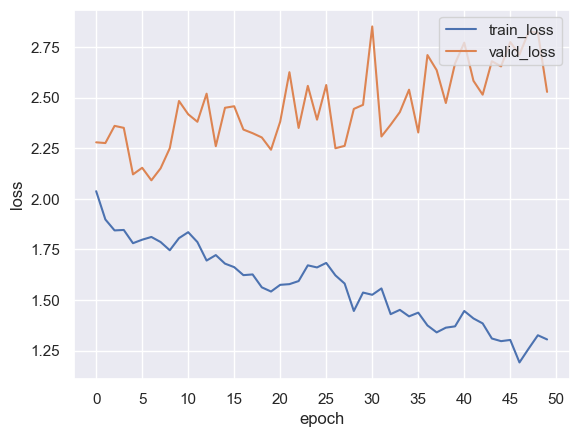

In [31]:
plot_loss(train_loss, valid_loss)

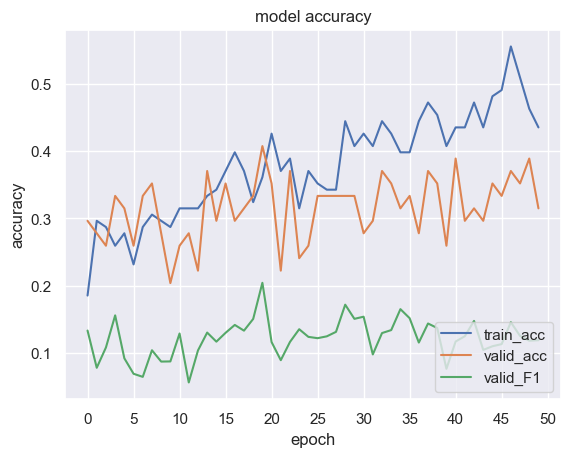

In [32]:
plot_metrics(train_acc, valid_acc, valid_f1)

In [33]:
print(f'accuracy: {max(valid_acc)}, f1 score: {max(valid_f1)}')

accuracy: 0.4074074074074074, f1 score: 0.204135101010101


## N分類モデル

In [34]:
batch_size=4
epochs=50
learning_rate=1e-5
momentum=0.9

In [35]:
train_data = []
valid_data = []
for x, y in zip(X_train, Yn_train):
    data = [x, y]
    train_data.append(data)
for x, y in zip(X_valid, Yn_valid):
    data = [x, y]
    valid_data.append(data)
    
train_loader, valid_loader = build_data(train_data, valid_data, batch_size=batch_size)

In [36]:
config = BertConfig.from_json_file(model_path / 'bert_config.json')
bert = BertModel.from_pretrained(model_path / 'UTH_BERT.bin', config=config)
model = Net(bert, num_classes_n).to(device)

FREEZE=False
if FREEZE: 
    idx=1 #Any
    for name, param in model.named_parameters(): 
        param.requires_grad = False 
    for name, param in list(model.named_parameters())[idx:]: 
        param.requires_grad = True 
#     optimizer = optim.SGD([{'params':list(model.parameters())[idx:], 'lr':learning_rate, 'momentum':momentum}])
    optimizer = optim.Adam([{'params':list(model.parameters())[idx:], 'lr':learning_rate}]) 
    criterion = nn.CrossEntropyLoss()
else:  
#     optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

In [37]:
train_loss, valid_loss, train_acc, valid_acc, valid_f1 = run(train_loader, valid_loader, model,
                                                             num_classes_n, epochs=epochs,
                                                             save_path=save_path/'n')


Epoch 1/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 1.2446, Train acc: 0.4815, Time: 8s
Valid loss: 1.2453, Valid acc: 0.3519, Valid F1: 0.1301

Epoch 2/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 1.1701, Train acc: 0.3611, Time: 7s
Valid loss: 1.2111, Valid acc: 0.5741, Valid F1: 0.3081

Epoch 3/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 1.1732, Train acc: 0.4537, Time: 7s
Valid loss: 1.2480, Valid acc: 0.4815, Valid F1: 0.2597

Epoch 4/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 1.1911, Train acc: 0.3796, Time: 8s
Valid loss: 1.1840, Valid acc: 0.5000, Valid F1: 0.2538

Epoch 5/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 1.1774, Train acc: 0.4630, Time: 7s
Valid loss: 1.1160, Valid acc: 0.5556, Valid F1: 0.2875

Epoch 6/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 1.1987, Train acc: 0.4722, Time: 7s
Valid loss: 1.0718, Valid acc: 0.6111, Valid F1: 0.3250

Epoch 7/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 1.1879, Train acc: 0.4537, Time: 7s
Valid loss: 1.1469, Valid acc: 0.3704, Valid F1: 0.1351

Epoch 8/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 1.2228, Train acc: 0.4444, Time: 7s
Valid loss: 1.2665, Valid acc: 0.3704, Valid F1: 0.1351

Epoch 9/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 1.1908, Train acc: 0.4537, Time: 7s
Valid loss: 1.0860, Valid acc: 0.5741, Valid F1: 0.2858

Epoch 10/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 1.1934, Train acc: 0.4444, Time: 7s
Valid loss: 1.1055, Valid acc: 0.5185, Valid F1: 0.2708

Epoch 11/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 1.1850, Train acc: 0.4259, Time: 7s
Valid loss: 1.1302, Valid acc: 0.3333, Valid F1: 0.1596

Epoch 12/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 1.1582, Train acc: 0.4815, Time: 7s
Valid loss: 1.1383, Valid acc: 0.5741, Valid F1: 0.3000

Epoch 13/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 1.0901, Train acc: 0.5000, Time: 7s
Valid loss: 1.1457, Valid acc: 0.5370, Valid F1: 0.2752

Epoch 14/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 1.1360, Train acc: 0.4259, Time: 7s
Valid loss: 1.2423, Valid acc: 0.4630, Valid F1: 0.2493

Epoch 15/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 1.1342, Train acc: 0.4537, Time: 7s
Valid loss: 1.0537, Valid acc: 0.6296, Valid F1: 0.3275

Epoch 16/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 1.0488, Train acc: 0.5093, Time: 7s
Valid loss: 1.2350, Valid acc: 0.5556, Valid F1: 0.2987

Epoch 17/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 1.1708, Train acc: 0.4352, Time: 7s
Valid loss: 1.3542, Valid acc: 0.4259, Valid F1: 0.2303

Epoch 18/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 1.2518, Train acc: 0.4630, Time: 8s
Valid loss: 1.0458, Valid acc: 0.5185, Valid F1: 0.2845

Epoch 19/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 1.1249, Train acc: 0.4907, Time: 7s
Valid loss: 1.0335, Valid acc: 0.5556, Valid F1: 0.2990

Epoch 20/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 1.0740, Train acc: 0.4907, Time: 8s
Valid loss: 1.2329, Valid acc: 0.3704, Valid F1: 0.1866

Epoch 21/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 1.0885, Train acc: 0.4907, Time: 7s
Valid loss: 1.1071, Valid acc: 0.4630, Valid F1: 0.2550

Epoch 22/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 1.0195, Train acc: 0.5833, Time: 7s
Valid loss: 1.1928, Valid acc: 0.5370, Valid F1: 0.2778

Epoch 23/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 0.9761, Train acc: 0.6019, Time: 7s
Valid loss: 1.2179, Valid acc: 0.5000, Valid F1: 0.2775

Epoch 24/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 0.9449, Train acc: 0.5741, Time: 7s
Valid loss: 1.1265, Valid acc: 0.5556, Valid F1: 0.2883

Epoch 25/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 1.1970, Train acc: 0.4722, Time: 7s
Valid loss: 1.3311, Valid acc: 0.4259, Valid F1: 0.1679

Epoch 26/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 1.2338, Train acc: 0.4259, Time: 7s
Valid loss: 1.0649, Valid acc: 0.5185, Valid F1: 0.3464

Epoch 27/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 1.1044, Train acc: 0.5093, Time: 7s
Valid loss: 1.1133, Valid acc: 0.5370, Valid F1: 0.2881

Epoch 28/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 1.0140, Train acc: 0.5093, Time: 7s
Valid loss: 1.1534, Valid acc: 0.5926, Valid F1: 0.3090

Epoch 29/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 1.0796, Train acc: 0.4444, Time: 7s
Valid loss: 1.3015, Valid acc: 0.4074, Valid F1: 0.2125

Epoch 30/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 1.0616, Train acc: 0.5278, Time: 7s
Valid loss: 1.2498, Valid acc: 0.2963, Valid F1: 0.1641

Epoch 31/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 0.9580, Train acc: 0.5648, Time: 7s
Valid loss: 1.2536, Valid acc: 0.4074, Valid F1: 0.2263

Epoch 32/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 1.0261, Train acc: 0.5278, Time: 7s
Valid loss: 1.1866, Valid acc: 0.5185, Valid F1: 0.3305

Epoch 33/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 0.9988, Train acc: 0.5278, Time: 7s
Valid loss: 1.2861, Valid acc: 0.4444, Valid F1: 0.2495

Epoch 34/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 0.9481, Train acc: 0.5648, Time: 7s
Valid loss: 1.2703, Valid acc: 0.5185, Valid F1: 0.2915

Epoch 35/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 1.0124, Train acc: 0.5556, Time: 7s
Valid loss: 1.1102, Valid acc: 0.5185, Valid F1: 0.2886

Epoch 36/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 0.9758, Train acc: 0.5556, Time: 7s
Valid loss: 1.2389, Valid acc: 0.5000, Valid F1: 0.2886

Epoch 37/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 0.9946, Train acc: 0.5556, Time: 7s
Valid loss: 1.0750, Valid acc: 0.6111, Valid F1: 0.3399

Epoch 38/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 0.9006, Train acc: 0.6019, Time: 7s
Valid loss: 1.1357, Valid acc: 0.4815, Valid F1: 0.2668

Epoch 39/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 0.9055, Train acc: 0.6111, Time: 7s
Valid loss: 1.3345, Valid acc: 0.4444, Valid F1: 0.3006

Epoch 40/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 0.9978, Train acc: 0.5093, Time: 7s
Valid loss: 1.1134, Valid acc: 0.6296, Valid F1: 0.4095

Epoch 41/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 0.9334, Train acc: 0.5741, Time: 7s
Valid loss: 1.2831, Valid acc: 0.5370, Valid F1: 0.3726

Epoch 42/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 0.9784, Train acc: 0.5000, Time: 7s
Valid loss: 1.4051, Valid acc: 0.4444, Valid F1: 0.2951

Epoch 43/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 0.9252, Train acc: 0.5000, Time: 7s
Valid loss: 1.2357, Valid acc: 0.5926, Valid F1: 0.3812

Epoch 44/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 0.9169, Train acc: 0.5833, Time: 7s
Valid loss: 1.1515, Valid acc: 0.5741, Valid F1: 0.3746

Epoch 45/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 0.9548, Train acc: 0.6111, Time: 7s
Valid loss: 1.0032, Valid acc: 0.6111, Valid F1: 0.3931

Epoch 46/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 0.9403, Train acc: 0.5926, Time: 8s
Valid loss: 1.1562, Valid acc: 0.5185, Valid F1: 0.3391

Epoch 47/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 0.9300, Train acc: 0.5741, Time: 7s
Valid loss: 1.2274, Valid acc: 0.5370, Valid F1: 0.3538

Epoch 48/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 0.8740, Train acc: 0.5926, Time: 7s
Valid loss: 1.1436, Valid acc: 0.5370, Valid F1: 0.2978

Epoch 49/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 0.9437, Train acc: 0.6111, Time: 7s
Valid loss: 1.2942, Valid acc: 0.5556, Valid F1: 0.3122

Epoch 50/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 0.8734, Train acc: 0.6296, Time: 8s
Valid loss: 1.4102, Valid acc: 0.5556, Valid F1: 0.3095

Training complete
Best ACC: 0.6296 at epoch 14
Best F1: 0.4095 at epoch 39


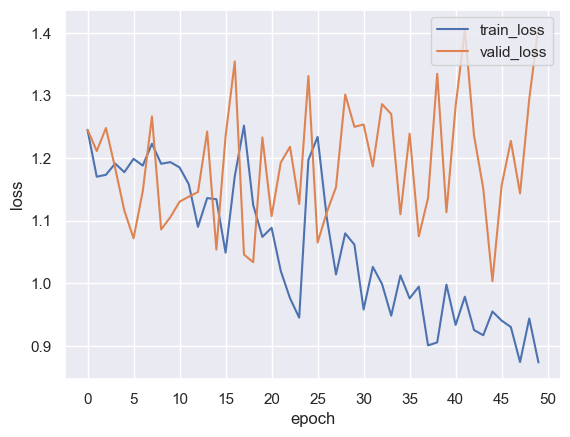

In [38]:
plot_loss(train_loss, valid_loss)

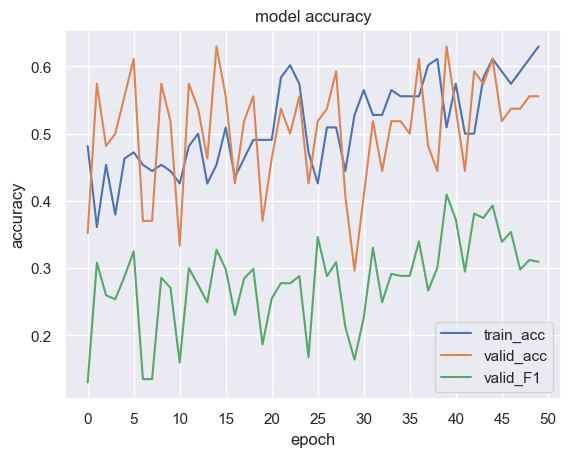

In [39]:
plot_metrics(train_acc, valid_acc, valid_f1)

In [40]:
print(f'accuracy: {max(valid_acc)}, f1 score: {max(valid_f1)}')

accuracy: 0.6296296296296297, f1 score: 0.40948525159051474


## M分類モデル

In [41]:
batch_size=4
epochs=50
learning_rate=1e-5
momentum=0.9

In [42]:
train_data = []
valid_data = []
for x, y in zip(X_train, Ym_train):
    data = [x, y]
    train_data.append(data)
for x, y in zip(X_valid, Ym_valid):
    data = [x, y]
    valid_data.append(data)
    
train_loader, valid_loader = build_data(train_data, valid_data, batch_size=batch_size)

In [43]:
config = BertConfig.from_json_file(model_path / 'bert_config.json')
bert = BertModel.from_pretrained(model_path / 'UTH_BERT.bin', config=config)
model = Net(bert, num_classes_m).to(device)

FREEZE=False
if FREEZE: 
    idx=1 #Any
    for name, param in model.named_parameters(): 
        param.requires_grad = False 
    for name, param in list(model.named_parameters())[idx:]: 
        param.requires_grad = True 
#     optimizer = optim.SGD([{'params':list(model.parameters())[idx:], 'lr':learning_rate, 'momentum':momentum}])
    optimizer = optim.Adam([{'params':list(model.parameters())[idx:], 'lr':learning_rate}]) 
    criterion = nn.CrossEntropyLoss()
else:  
#     optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

In [44]:
train_loss, valid_loss, train_acc, valid_acc, valid_f1 = run(train_loader, valid_loader, model,
                                                             num_classes_m, epochs=epochs,
                                                             save_path=save_path/'m')


Epoch 1/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 0.9859, Train acc: 0.6574, Time: 7s
Valid loss: 1.4752, Valid acc: 0.5370, Valid F1: 0.2945

Epoch 2/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 0.8776, Train acc: 0.6852, Time: 7s
Valid loss: 1.5133, Valid acc: 0.5185, Valid F1: 0.2601

Epoch 3/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 0.8080, Train acc: 0.7037, Time: 7s
Valid loss: 1.4633, Valid acc: 0.5000, Valid F1: 0.2778

Epoch 4/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 0.7566, Train acc: 0.7407, Time: 7s
Valid loss: 1.7547, Valid acc: 0.5926, Valid F1: 0.3942

Epoch 5/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 0.8200, Train acc: 0.6944, Time: 7s
Valid loss: 1.6686, Valid acc: 0.5556, Valid F1: 0.2468

Epoch 6/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 0.7583, Train acc: 0.7130, Time: 7s
Valid loss: 1.7817, Valid acc: 0.5926, Valid F1: 0.3818

Epoch 7/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 0.8329, Train acc: 0.6574, Time: 7s
Valid loss: 1.6744, Valid acc: 0.5000, Valid F1: 0.2222

Epoch 8/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 0.7368, Train acc: 0.7315, Time: 7s
Valid loss: 1.5633, Valid acc: 0.5185, Valid F1: 0.3447

Epoch 9/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 0.8846, Train acc: 0.6574, Time: 7s
Valid loss: 1.5723, Valid acc: 0.5926, Valid F1: 0.3766

Epoch 10/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 0.7230, Train acc: 0.7685, Time: 7s
Valid loss: 1.6962, Valid acc: 0.5926, Valid F1: 0.4014

Epoch 11/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 0.7350, Train acc: 0.7407, Time: 7s
Valid loss: 1.7279, Valid acc: 0.6296, Valid F1: 0.3198

Epoch 12/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 0.6501, Train acc: 0.7500, Time: 7s
Valid loss: 1.6409, Valid acc: 0.6111, Valid F1: 0.4004

Epoch 13/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 0.6854, Train acc: 0.7407, Time: 7s
Valid loss: 1.7419, Valid acc: 0.5926, Valid F1: 0.2959

Epoch 14/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 0.6839, Train acc: 0.7593, Time: 7s
Valid loss: 1.7436, Valid acc: 0.6111, Valid F1: 0.4067

Epoch 15/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 0.7014, Train acc: 0.7130, Time: 7s
Valid loss: 1.9256, Valid acc: 0.5000, Valid F1: 0.1709

Epoch 16/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 0.6414, Train acc: 0.7593, Time: 7s
Valid loss: 1.6923, Valid acc: 0.6111, Valid F1: 0.4067

Epoch 17/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 0.6074, Train acc: 0.7963, Time: 7s
Valid loss: 1.8489, Valid acc: 0.5741, Valid F1: 0.3511

Epoch 18/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 0.6906, Train acc: 0.7407, Time: 7s
Valid loss: 1.6580, Valid acc: 0.6111, Valid F1: 0.3101

Epoch 19/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 0.6205, Train acc: 0.7685, Time: 7s
Valid loss: 1.8281, Valid acc: 0.5926, Valid F1: 0.2887

Epoch 20/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 0.5945, Train acc: 0.7685, Time: 7s
Valid loss: 2.0713, Valid acc: 0.5000, Valid F1: 0.2044

Epoch 21/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 0.6886, Train acc: 0.7500, Time: 7s
Valid loss: 1.9656, Valid acc: 0.5741, Valid F1: 0.3550

Epoch 22/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 0.6167, Train acc: 0.7778, Time: 7s
Valid loss: 2.0871, Valid acc: 0.5741, Valid F1: 0.2670

Epoch 23/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 0.6279, Train acc: 0.7593, Time: 7s
Valid loss: 1.7739, Valid acc: 0.5000, Valid F1: 0.2675

Epoch 24/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 0.5774, Train acc: 0.7870, Time: 7s
Valid loss: 1.8689, Valid acc: 0.6111, Valid F1: 0.4067

Epoch 25/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 0.6212, Train acc: 0.7593, Time: 7s
Valid loss: 1.8798, Valid acc: 0.5741, Valid F1: 0.2822

Epoch 26/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 0.6278, Train acc: 0.7870, Time: 7s
Valid loss: 1.9830, Valid acc: 0.5741, Valid F1: 0.2844

Epoch 27/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 0.6010, Train acc: 0.7963, Time: 7s
Valid loss: 1.7483, Valid acc: 0.6296, Valid F1: 0.4386

Epoch 28/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 0.6601, Train acc: 0.7685, Time: 7s
Valid loss: 1.5635, Valid acc: 0.6296, Valid F1: 0.3221

Epoch 29/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 0.6123, Train acc: 0.7685, Time: 7s
Valid loss: 1.9534, Valid acc: 0.5370, Valid F1: 0.2512

Epoch 30/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 0.6593, Train acc: 0.7315, Time: 7s
Valid loss: 1.8879, Valid acc: 0.5926, Valid F1: 0.2995

Epoch 31/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 0.5836, Train acc: 0.8056, Time: 7s
Valid loss: 1.7858, Valid acc: 0.5556, Valid F1: 0.2740

Epoch 32/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 0.6224, Train acc: 0.7963, Time: 7s
Valid loss: 2.1542, Valid acc: 0.5185, Valid F1: 0.2087

Epoch 33/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 0.5804, Train acc: 0.7500, Time: 7s
Valid loss: 1.9212, Valid acc: 0.5926, Valid F1: 0.3789

Epoch 34/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 0.5378, Train acc: 0.8241, Time: 7s
Valid loss: 2.2013, Valid acc: 0.5741, Valid F1: 0.2733

Epoch 35/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 0.6511, Train acc: 0.7500, Time: 7s
Valid loss: 1.6851, Valid acc: 0.5741, Valid F1: 0.2868

Epoch 36/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 0.6109, Train acc: 0.7685, Time: 7s
Valid loss: 2.0738, Valid acc: 0.5741, Valid F1: 0.3173

Epoch 37/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 0.6591, Train acc: 0.7778, Time: 7s
Valid loss: 1.8085, Valid acc: 0.6296, Valid F1: 0.4299

Epoch 38/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 0.6151, Train acc: 0.7500, Time: 7s
Valid loss: 1.9551, Valid acc: 0.6296, Valid F1: 0.3249

Epoch 39/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 0.6230, Train acc: 0.7778, Time: 7s
Valid loss: 2.0656, Valid acc: 0.5556, Valid F1: 0.2491

Epoch 40/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 0.6092, Train acc: 0.7685, Time: 7s
Valid loss: 2.0954, Valid acc: 0.6111, Valid F1: 0.4067

Epoch 41/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 0.5965, Train acc: 0.7407, Time: 7s
Valid loss: 1.9393, Valid acc: 0.5556, Valid F1: 0.2539

Epoch 42/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 0.5502, Train acc: 0.8148, Time: 7s
Valid loss: 2.1205, Valid acc: 0.5370, Valid F1: 0.2324

Epoch 43/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 0.5619, Train acc: 0.7870, Time: 7s
Valid loss: 1.9122, Valid acc: 0.5926, Valid F1: 0.2911

Epoch 44/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 0.5475, Train acc: 0.7963, Time: 7s
Valid loss: 2.1161, Valid acc: 0.5741, Valid F1: 0.2868

Epoch 45/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 0.5443, Train acc: 0.7963, Time: 7s
Valid loss: 1.7945, Valid acc: 0.5926, Valid F1: 0.3081

Epoch 46/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 0.5375, Train acc: 0.8056, Time: 7s
Valid loss: 1.9267, Valid acc: 0.6111, Valid F1: 0.3125

Epoch 47/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 0.5782, Train acc: 0.7593, Time: 7s
Valid loss: 1.9813, Valid acc: 0.5556, Valid F1: 0.2564

Epoch 48/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 0.5878, Train acc: 0.7778, Time: 7s
Valid loss: 2.0632, Valid acc: 0.5926, Valid F1: 0.3818

Epoch 49/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 0.6438, Train acc: 0.7593, Time: 7s
Valid loss: 1.9478, Valid acc: 0.5926, Valid F1: 0.3107

Epoch 50/50
----------


  0%|          | 0/27 [00:00<?, ?it/s]

Train loss: 0.6038, Train acc: 0.7685, Time: 7s
Valid loss: 2.0209, Valid acc: 0.5741, Valid F1: 0.2733

Training complete
Best ACC: 0.6296 at epoch 10
Best F1: 0.4386 at epoch 26


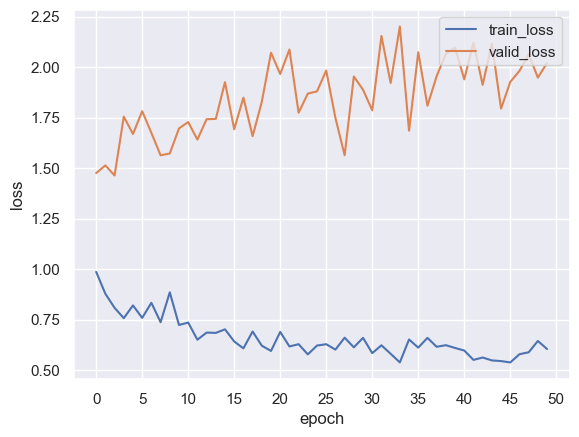

In [45]:
plot_loss(train_loss, valid_loss)

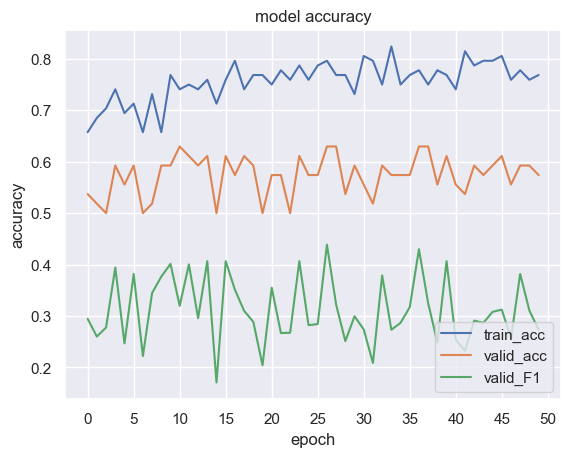

In [46]:
plot_metrics(train_acc, valid_acc, valid_f1)

In [47]:
print(f'accuracy: {max(valid_acc)}, f1 score: {max(valid_f1)}')

accuracy: 0.6296296296296297, f1 score: 0.4386464263124605
